# Player Props with Python

This post is the start in a series of posts (hopefully) on probability theory and how to apply it and the associated tools we have at our disposal in Python to sports betting. We are starting this post a bit late in the NFL season (there's literally one game left in the season), but we're hoping to also come out with betting content related to the NBA, so stay tuned and join our mailing list for updates on that.

In previous content, we haven't focused too much on either betting or probability theory. That's partly because I never really bet before, and I generally stuck to what I know which is traditional, redraft Fantasy Football. That all changed when I hit 2 parlays two weekends in a row this NFL playoffs (took Bengals over Bills money line and SF to cover the spread, then took KC money line and Eagles to cover the spread) and turned 25 dollars in 575. Not bragging since I probably just rewired my brain circuitry to never enjoy another NFL game again without a having a little action on (gamble at your own risk, please). So essentially I got traded $550 for the inability to ever again just sit comfortably and watch the game with the boys. I got the itch now, so to speak, which is half the reason I'm writing a lengthy post on doing this stuff in Python (and also planning on releasing a whole course).

The focus of this post will be for finding potentially profitable bets for this year's Super Bowl. We will do so by teaching you a little bit about probability, then applying two different probability distributions to two different types of props (just to keep things simple), calculating probabilities for outcomes, and then comparing that to the implied probability of the lines we get from our sports book. 

# How to Think Like a Profitable Bettor

Our rule will be that if the probability we calculate of an outcome ocurring is greater than the implied probability from the money line, then we take that bet. That should, in theory, make the bet positive expected value (or EV, for short). 

It's worthy to note that just because we take a positive EV bet, doesn't make it <i>likely</i> to hit. We could take a positive EV bet where the edge is 1%, that is the calculated probability we get from our analysis is 44% but the book is giving us 43% odds. There's still a 56% chance we lose our money, or more likely than not. It's positive EV because that 1% profit margin will be realized over time, or over a series of many bets. The essence of having an edge in any probabilistic endeavour like sports betting is that the edge is unfolded over time, but there is of course an element of randomness that prevents a bettor from having strong predictability around individual occurences (bets). 

I personally learned this way of thinking through trading and investing, and it's exactly this mindset that's taught to successful investors. It applies equally here in sports betting just as well. The difference though is that it's actually <i>easier</i> to think this way in sports betting, because your R-factor, or risk-to-reward ratio, is already explicitly set by the money line, whereas in investing these things are more fluid and you must set the R-factor yourself. 

Remember that we are implying the probabilities from the lines, but what the line is <i>explicitly</i> telling us is our risk-to-reward ratio. If we have a bet that's +200, that's a 2 to 1 payout, and a 33% implied probability (100/200+100). 33% is also our breakeven point on any 2-1 bet, ever. Which means, if we consistently took +200 bets, we would need a 33% win rate to breakeven. If we are able to push our win rate above 33%, even to say 35%, we've developed an edge and positive EV. 

This also means, that by definition, just taking sports bets at random, your EV is 0 and you are expected to lose no money and gain no money assuming Vegas is right over the long run (it's not a bad assumption to make).

This example assumes you use proper bet sizing and money management to not irresponsibly increase your risk of ruin, and also assumes no transaction costs which would push your EV below 0 (there's always transaction costs, so our perfect world example does fail). 

This is also on average. Depending on how conservatively you bet, you may just lose all of your money just off bad luck (variance). For this reason, only ever bet money you are willing to lose.

In investing, literally no one will set that fixed payout structure for you, which can be the most challenging part of the risk management component of investing, intellectually and psychologically. 

We have a head start when coming to sports betting, and we should probably take advantage of that fact (Along with other advantages, including the fact that sports betting markets are signifcantly less efficient than global financial markets).

# Super Bowl Lines

We'll only be covering a single player prop here, since this post will end up being quite long. We'll be looking at the O/U for Jalen Hurts pass attempts, which is currently +100 for over 31.5 attempts on DraftKings. However, you're welcome to also apply this code to other player props that might be well-modeled by the distribution we'll discuss (Poisson).

# Into the Code

We're going to be pulling our data from `nfl-data-py`, which conviently provides weekly data alongside play-by-play data. We'll be pulling weekly stat data for each of our players above, then processing and formatting their data to fit a distribution and estimate calcalated probabilities.

We'll go into the theory as we write the code, since we've already talked a good amount of theory so far without writing any code. Below, we pip install `nfl-data-py`, and then import the libraries we'll be using  in this notebook.

In [8]:
%%capture
%pip install nfl-data-py

In [9]:
import nfl_data_py as nfl
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

random = np.random.default_rng(42)

plt.style.use('ggplot')

We've pulled the lines below from Draftkings. You're welcome to use another book, or several books, but we're using only one here for the sake of simplicity. We'll set these lines and over/unders to some variables we can reference later in our code.

In [24]:
hurts_pa_ou = 31.5
hurts_pa_line = +100 # for the over

Let's start with something simple: the code block defines a function named `implied_probability` that takes in two parameters: `money_line` and `round_n`.

The `money_line` parameter is a betting line that represents the odds of a particular outcome happening in a sports event. A negative money line means the outcome is favored to happen, while a positive money line means the outcome is an underdog.

The `round_n` parameter is the number of decimal places to which the result of the calculation should be rounded. The default value of this parameter is 2, if it is not provided as an argument.

The function uses an if-else statement to determine the implied probability based on the value of the `money_line` parameter:

<ul>
<li>If the money line is less than 0, the implied probability is calculated by dividing the money line by (money line - 100) and rounding the result to the specified number of decimal places.</li>

<li>If the money line is greater than or equal to 0, the implied probability is calculated by subtracting (money line / (money line + 100)) from 1 and rounding the result to the specified number of decimal places.</li>
</ul>

In [25]:
def implied_probability(money_line, round_n=2):
    if money_line < 0:
        return round(money_line / (money_line - 100), round_n)
    else:
        return round(1 - (money_line / (money_line + 100)), round_n)

ip_x = implied_probability(hurts_pa_line)  
print(f'Implied probability of over {hurts_pa_ou} pass attempts for Hurts in the Super Bowl is: ', ip_x)

Implied probability of over 31.5 pass attempts for Hurts in the Super Bowl is:  0.5


Next, let's import weekly data for Hurts from nfl-data-py. We'll grab the `attempts` column from his DataFrame, and convert it to an array using the `values` attribute.

In [26]:
#load our data for hurts
weekly_data = nfl.import_weekly_data(years=range(2021, 2023), columns=['player_name', 'attempts'])
hurts_pa = weekly_data.loc[weekly_data['player_name'] == 'J.Hurts'].attempts.values

hurts_pa

Downcasting floats.


array([35, 23, 39, 48, 37, 26, 34, 14, 17, 23, 24, 31, 26, 29, 26, 43, 32,
       31, 35, 25, 36, 25, 28, 27, 26, 25, 28, 39, 31, 37, 35, 24, 25],
      dtype=int32)

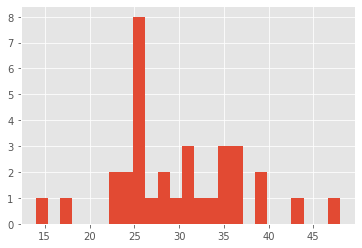

In [27]:
plt.hist(hurts_pa, bins=25);

In [28]:
print('Sample size: ', len(hurts_pa))
print('Mean: ', hurts_pa.mean())
print('Median: ', np.median(hurts_pa))
print('Standard deviation: ', hurts_pa.std())

Sample size:  33
Mean:  29.818181818181817
Median:  28.0
Standard deviation:  7.098674846265517


Here, we plotted Hurts passing attempt data and printed out some summary descriptive statistics to get a better sense of how his pass attempts are distributed. We're going to be mostly interested in the mean here.

In a moment, you'll see where we're going with all this, but essentially we are in the process of trying to get a sense of what probability distribution would best model the data-generating process for pass attempts and how well the sample's summary statistics represent the potential population.

Generally speaking, when dealing with football data, we're going to have to be a bit creative as we don't awlays have the largest sample sizes. The larger our sample size, the more certain we can be that whatever statistics we pull from the sample represent the population. 

Let's try doing some bootstrap resampling to find a confidence interval for the mean (which will end up being the sole parameter we'll use for our distribution we'll fit to the data). 

Boostrap resampling is essentially a stastical technique which name comes from the phrase "pulling yourself up by the bootstraps". Essentially it used in situations where you'd like to gather more samples to better estimate a stastitic, like the mean, but don't have the means (no pun intended) to do so. Usually this is done in cases where repeating trials for a sample would be timely or costly, and so bootstrap resampling is the "economic" choice. 

In our case, we'd have to just wait for Hurts to keep playing games for us to collect more samples. 

Instead, we can draw samples from a distribution (which can be thought of as Hurts "range of outcomes" for pass attempts) with replacement equal to length of our original data (which can be thought of as the number of samples of actual pass attempts available to us at this point in his career). So, we are essentialy re-sampling Jalen Hurts career over and over again with random samples from his current pass attempt distribution. Note, with replacement means that when we draw samples we allow duplicates. We then take whatever statistic we are trying to estimate, in this case the mean, and set it away in a seperate array (`xs` below), and then examine the distribution for that summary statistic. 

In [29]:
# sampling with replacement first
xs = np.array([])
n_simulations = 10_000

for _ in range(n_simulations):
    boot_x = np.random.choice(hurts_pa, size=len(hurts_pa), replace=True).mean()
    xs =  np.append(xs, boot_x)
    
xs

array([32.60606061, 32.06060606, 30.18181818, ..., 28.03030303,
       28.81818182, 31.39393939])

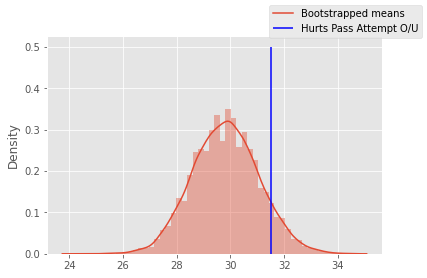

In [30]:
sns.distplot(xs);
plt.gca().vlines(x=hurts_pa_ou, ymin=0, ymax=0.5, color='blue');
plt.gcf().legend(['Bootstrapped means', 'Hurts Pass Attempt O/U']);

#for later
kde_data_x, kde_data_y = plt.gca().lines[0].get_data()

This graph shows us the distribution of bootstrapped means from out random re-sampling of Jalen Hurts Career. As you can see, there is a small chance that Jalen Hurts long-run pass attempt volume could be as high as 34 and as low as 24. It is highly unlikely that is the case based on what we have seen from Jalen Hurts, but it is not impossible. It is more likely that Jalen Hurts "true" long-run average is close to his current career average of 29 and the distribution reflects that. Also, notice that we are saving the data used to plot these lines as kde_data_x and kde_data_y. This will help us visualize whether or not an over or under bet is + EV. 

In [38]:
lower_bound, upper_bound = np.quantile(xs, 0.025), np.quantile(xs, 0.975)
lower_bound, upper_bound

(27.48409090909091, 32.303030303030305)

We can be fairly certain that Hurts long-run passing attempt average lies somewhere between 27.39 and 32.21 (only 2.5% of values fell below the former, and only 2.5% of values fell above the latter).

Now let's generate a poission distribution, with first our original calculated mean for Hurts which is 29.8ish, run a bunch of simulated draws from that distribution and calculate the long run frequency of drawing a value above 31.5.

Then we'll essentially stress test our model by calculating that long-run frequency with the lower and upper bounds of our confidence interval for the boostrap resampling technique we did above. We'll say that if the calculated probability of the over hitting on the upper bound of the confidence interval for what Hurts average PA/game should be is < implied probability of the over hitting, we take the bet. 

I'm not sure if this is how pro better's do it, although I know for a fact they go for +EV. In investing, this is akin to the concept of "Margin of Safety". This is the concept of only buying up stocks where the calculated intrinsic value of the stock < market value by a wide margin (legendary investors like Buffet won't invest unless the stock is trading at at least a 20% discount), to protect you from uncertainty and essentially boost your edge. It's a way of reducing your risk and making sure you only take the surest things, even though a sure thing doesn't exist in investing or gambling.

We'll fit an empirical density function to the data to show that pass attempts should in theory match a Poisson distribution.

You're probably wondering what a Poisson distribution even is. A Poisson distribution is a discrete probability distribution where the timing of events are independent from each other. It has one parameter, lambda, which is the rate at which events occur per unit time. Here, we use mean pass attempts per game as our lambda. 

The quintessential example of a Poisson process is a bus stop where the timing of one bus arriving is completely independent of when the last bus got there. You could be waiting 5 minutes, or 2 hours. Interestingly, the time between events in a Poisson distribution can be modeled via an exponential distribution, which is an example of a continuous probability distribution. A Poisson distribution seems like a good fit for passing attempts, considering that there is a more-or-less consistent time window across samples (not truly, while every game in the NFL is the same length in theory, there's rule stating that the offense needs to be on the field for X amount of time each game. Not to mention overtime), and the timing between pass attempts is independent (I think you could make a stronger case on this point here).

If this is going a little too fast for you, no worries, we will revist these concepts in future posts.

In [39]:
poisson_arr = np.random.poisson(lam=hurts_pa.mean(), size=n_simulations)

calculated_probability = sum(poisson_arr > hurts_pa_ou) / n_simulations
print(calculated_probability)
if calculated_probability > ip_x:
    print('Take the over')
else:
    print('Take the under')

0.365
Take the under


As we discussed above, however, we can't always be sure that our sample statistics generalize to the mean well. This is why we used bootstrapping to come up with a distribution of what our true mean might be. Let's calculate a "best-case" calculated probability and "worst-case" calculated probability for Hurts using a lower bound of 2.5% and upper bound of 97.5% or 95% confidence interval.

In [40]:
poisson_arr_lower_bound = np.random.poisson(lam=lower_bound, size=n_simulations)
calculated_probability_lower_bound = sum(poisson_arr_lower_bound > hurts_pa_ou) / n_simulations
calculated_probability_lower_bound

0.2137

In [41]:
poisson_arr_upper_bound = np.random.poisson(lam=upper_bound, size=n_simulations)
calculated_probability_upper_bound = sum(poisson_arr_upper_bound > hurts_pa_ou) / n_simulations
calculated_probability_upper_bound, round(ip_x, 4)

(0.5461, 0.5)

Now, we can actually show how our edge changes given a change in our estimate for Hurts pass attempts per game!

We can do this by generating quantiles, or cut points that divide our range of probabilities, equal to length of our KDE data we saved earlier, calculating the probability at each quantile for our bootstrap array, and then generating some x data to help us plot things. The code for that is below: 

In [36]:
def calculate_probability(lam, n_simulations=200_000):
    draws = np.random.poisson(lam=lam, size=n_simulations)
    return sum(draws > hurts_pa_ou) / n_simulations

quantiles = np.arange(1, len(kde_data_x)) / len(kde_data_y)
y = np.array([calculate_probability(np.quantile(xs, i/len(quantiles))) for i in range(1, len(quantiles) + 1)])
x = np.array([np.quantile(xs, quantile) for quantile in quantiles])

This looks complicated, but what we did here is create a function that calculates the probability for every qunatile within our distirbution of bootstrapped means.

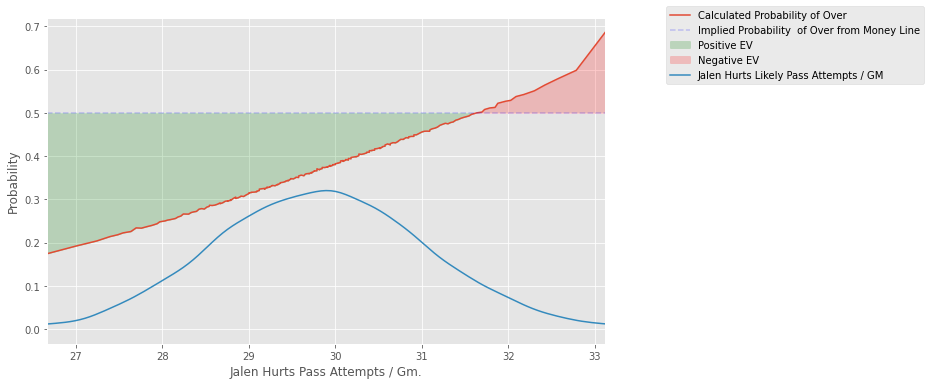

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, y);
ax.hlines(xmin=x.min(), xmax=x.max(), y=ip_x, color='blue', alpha=0.2, linestyle='--');
ax.fill_between(
    x, y, ip_x, color='green', alpha=0.2, where=y<ip_x
)
ax.fill_between(
    x, y, ip_x, color='red', alpha=0.2, where=y>ip_x*0.99
);

ax.set_ylabel('Probability')
ax.set_xlabel('Jalen Hurts Pass Attempts / Gm.');

ax.plot(kde_data_x, kde_data_y);
ax.set_xlim([x.min(), x.max()]);

ax.legend(['Calculated Probability of Over', 'Implied Probability  of Over from Money Line', 'Positive EV', 'Negative EV', 'Jalen Hurts Likely Pass Attempts / GM'], bbox_to_anchor=(1.1, 1.05));

For now, how this plot was generated as not as important as understanding what it means. The blue line is simply our bootstrapped means distribution from earlier. We've labeled that as "Jalen Hurts likely pass attempts/GM". The dotted line marks the implied probability of over 31.5 pass attempts hitting according to the line at DraftKings Sportsbook. The solid red line is the calculated probability of the number of pass attampts hitting at each quantile we calculated in the function above. 